# CSCI-6364 Final Project
# Data 
## Analysis

In [1]:
import pandas as pd
import numpy as np

In [2]:
df = pd.read_json("./data/train.jsonl", lines=True)
df_val = pd.read_json("./data/validation.jsonl", lines=True)
df_test = pd.read_json("./data/test.jsonl", lines=True)

In [3]:
df.head()

,text,label,label_text
0,i didnt feel humiliated,0,sadness
1,i can go from feeling so hopeless to so damned...,0,sadness
2,im grabbing a minute to post i feel greedy wrong,3,anger
3,i am ever feeling nostalgic about the fireplac...,2,love
4,i am feeling grouchy,3,anger


In [4]:
print(f"Training samples: {len(df)},\nvalidation samples: {len(df_val)}\nTest Samples: {len(df_test)}")

Training samples: 16000,
validation samples: 2000
Test Samples: 2000


In [5]:
print("Target variable distribution in training set: ")
print(df.label_text.value_counts().to_dict())

Target variable distribution in training set: 
{'joy': 5362, 'sadness': 4666, 'anger': 2159, 'fear': 1937, 'love': 1304, 'surprise': 572}


In [6]:
print("Unique labels ")
print(df.label_text.unique())

Unique labels 
['sadness' 'anger' 'love' 'surprise' 'fear' 'joy']


## Data Pre-Processing 
### Bag of Words and TF-IDF representations

In [7]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk import PorterStemmer, WordNetLemmatizer

In [8]:
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/diadochus/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /home/diadochus/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [9]:
STOP_WORDS = set(stopwords.words("english"))

In [10]:
# words are converted into shorten root words to remove redundancy
# STEMMER = PorterStemmer()
# Stemming produces Intermediate representation of word. It may or may not return meaningful word.
LEMMATIZER = WordNetLemmatizer()

In [11]:
def preprocessing(sentence: str):
    # convert to lower case and tokenize words
    word_tokens = word_tokenize(sentence.lower())
    # remove stop words from the sentence.
    filtered_sentence = [w for w in word_tokens if not w in STOP_WORDS]
    # Stemming
    # filtered_sentence = [STEMMER.stem(w) for w in filtered_sentence]
    # Lemmatization
    filtered_sentence = [LEMMATIZER.lemmatize(w) for w in filtered_sentence]
    
    return " ".join(filtered_sentence)

In [12]:
# input text
print("Unprocessed text: \n\n", df.text.iloc[1]) 

Unprocessed text: 

 i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake


In [13]:
# processed text
print("Processed text: \n\n", preprocessing(df.text.iloc[1])) 

Processed text: 

 go feeling hopeless damned hopeful around someone care awake


In [14]:
df = df.assign(processed_text=df.text.apply(lambda x: preprocessing(x)))
df_val = df_val.assign(processed_text=df_val.text.apply(lambda x: preprocessing(x)))
df_test = df_test.assign(processed_text=df_test.text.apply(lambda x: preprocessing(x)))

In [15]:
df.head()

,text,label,label_text,processed_text
0,i didnt feel humiliated,0,sadness,didnt feel humiliated
1,i can go from feeling so hopeless to so damned...,0,sadness,go feeling hopeless damned hopeful around some...
2,im grabbing a minute to post i feel greedy wrong,3,anger,im grabbing minute post feel greedy wrong
3,i am ever feeling nostalgic about the fireplac...,2,love,ever feeling nostalgic fireplace know still pr...
4,i am feeling grouchy,3,anger,feeling grouchy


### Simple Features: Bag of Words and TF-IDF

In [15]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [16]:
def get_simple_features(
    vectorizer,  # Bag of words or TF-IDF vectorizer
    df_train,
    df_validation,
    df_test,
    text_col="processed_text", 
    label_col="label"
) -> dict:
    """Transforms text data to BOW or TF-IDF representation."""
    # fit and transform training data
    X = vectorizer.fit_transform(df_train[text_col].tolist()) 
    X_train = X.toarray()
    y_train = df_train[label_col].to_numpy()
    
    # generate validation data
    X_val = vectorizer.transform(df_validation[text_col].tolist())
    X_val = X_val.toarray()
    y_val = df_validation[label_col].to_numpy()
    
    # generate test data
    X_test = vectorizer.transform(df_test[text_col].tolist())
    X_test = X_test.toarray()
    y_test = df_test[label_col].to_numpy()
    
    return_dict = {
        "train": {"x": X_train, "y": y_train},
        "validation": {"x": X_val, "y": y_val},
        "test": {"x": X_test, "y": y_test},
    }
    
    return return_dict

In [17]:
# get Bag-of-Words representations
bow_dataset = get_simple_features(
    vectorizer=CountVectorizer(),
    df_train=df,
    df_validation=df_val,
    df_test=df_test
)

In [18]:
# get Bag-of-Words representations
tfidf_dataset = get_simple_features(
    vectorizer=TfidfVectorizer(),
    df_train=df,
    df_validation=df_val,
    df_test=df_test
)

In [202]:
# save the data as pickle files.
import pickle

with open("./data/bow.pickle", "wb") as handle:
    pickle.dump(bow_dataset, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
with open("./data/tfidf.pickle", "wb") as handle:
    pickle.dump(tfidf_dataset, handle, protocol=pickle.HIGHEST_PROTOCOL)

#with open("./data/bow.pickle", "rb") as handle:
#    bow_dataset = pickle.load(handle)

### Embedding Features: get sentence embedding

In [6]:
from sentence_transformers import SentenceTransformer

In [14]:
def get_sent_embedding_features(
    df_train,
    df_validation,
    df_test,
    text_col="text", 
    label_col="label"
) -> dict:
    # initialize the model 
    vectorizer = SentenceTransformer("all-MiniLM-L6-v2")
    
    """Transforms text data to BOW or TF-IDF representation."""
    # fit and transform training data
    X_train = vectorizer.encode(df_train[text_col].tolist()) 
    y_train = df_train[label_col].to_numpy()
    
    # generate validation data
    X_val = vectorizer.encode(df_validation[text_col].tolist())
    y_val = df_validation[label_col].to_numpy()
    
    # generate test data
    X_test = vectorizer.encode(df_test[text_col].tolist())
    y_test = df_test[label_col].to_numpy()
    
    return_dict = {
        "train": {"x": X_train, "y": y_train},
        "validation": {"x": X_val, "y": y_val},
        "test": {"x": X_test, "y": y_test},
    }
    
    return return_dict

In [17]:
# get Bag-of-Words representations
semb_dataset = get_sent_embedding_features(
    df_train=df,
    df_validation=df_val,
    df_test=df_test
)

In [19]:
# save data as pickle file
import pickle

with open("./data/sent_emb.pickle", "wb") as handle:
    pickle.dump(semb_dataset, handle, protocol=pickle.HIGHEST_PROTOCOL)

# Models

## Naive Bayes

In [19]:
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.metrics import classification_report, f1_score

In [27]:
clf = GaussianNB()
clf.fit(tfidf_dataset["train"]["x"], tfidf_dataset["train"]["y"])
nb_predictions = clf.predict(tfidf_dataset["validation"]["x"])
print(classification_report(tfidf_dataset["validation"]["y"], nb_predictions))

              precision    recall  f1-score   support

           0       0.40      0.23      0.29       550
           1       0.54      0.23      0.32       704
           2       0.18      0.42      0.25       178
           3       0.31      0.31      0.31       275
           4       0.21      0.38      0.27       212
           5       0.11      0.42      0.17        81

    accuracy                           0.28      2000
   macro avg       0.29      0.33      0.27      2000
weighted avg       0.38      0.28      0.29      2000



In [28]:
clf = BernoulliNB()
clf.fit(tfidf_dataset["train"]["x"], tfidf_dataset["train"]["y"])
nb_predictions = clf.predict(tfidf_dataset["validation"]["x"])
print(classification_report(tfidf_dataset["validation"]["y"], nb_predictions))

              precision    recall  f1-score   support

           0       0.64      0.94      0.76       550
           1       0.71      0.93      0.80       704
           2       0.68      0.10      0.17       178
           3       0.88      0.45      0.60       275
           4       0.85      0.41      0.55       212
           5       0.00      0.00      0.00        81

    accuracy                           0.70      2000
   macro avg       0.63      0.47      0.48      2000
weighted avg       0.70      0.70      0.65      2000



In [29]:
nb_predictions = clf.predict(tfidf_dataset["test"]["x"])
print(classification_report(tfidf_dataset["test"]["y"], nb_predictions))

              precision    recall  f1-score   support

           0       0.65      0.91      0.76       581
           1       0.71      0.96      0.81       695
           2       0.79      0.09      0.17       159
           3       0.82      0.45      0.58       275
           4       0.78      0.29      0.42       224
           5       0.00      0.00      0.00        66

    accuracy                           0.70      2000
   macro avg       0.63      0.45      0.46      2000
weighted avg       0.70      0.70      0.65      2000



/home/diadochus/anaconda3/envs/hug/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/diadochus/anaconda3/envs/hug/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/diadochus/anaconda3/envs/hug/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitaliz

## SVM

In [19]:
#from sklearn.model_selection import GridSearchCV
from sklearn import svm

In [ ]:
# SVM Hyper-parameters.
kernels = ["linear", "poly", "rbf", "sigmoid", "precomputed"]
Cvalues = [1E-1, 1E0, 1E1, 1E2]

In [ ]:
# grid search for Bag of words
results = {"kernel": [], "C": [], "F1": []}
for kernel in kernels:
    for c in Cvalues:
        print(f"kernel: {kernel}, C: {c}")
        results["kernel"].append(kernel)
        results["C"].append(c)
        
        model = svm.SVC(kernel=kernel, C=c).fit(bow_dataset["train"]["x"], bow_dataset["train"]["y"])
        predict_dev = model.predict(bow_dataset["validation"]["x"])
        
        results["F1"].append(f1_score(bow_dataset["validation"]["y"], predict_dev, average="macro"))

In [ ]:
# evaluate BoW SVM models
dfr = pd.DataFrame.from_dict(results)
dfr = dfr.sort_values(by="F1", ascending=False).reset_index(drop=True)

best_kernel = dfr.kernel.tolist()[0]
best_c = dfr.C.tolist()[0]
model = svm.SVC(kernel=best_kernel, C=best_c).fit(bow_dataset["train"]["x"], bow_dataset["train"]["y"])
predict_test = model.predict(bow_dataset["test"]["x"])
        
print("Best F1 score: ", f1_score(bow_dataset["test"]["y"], predict_test, average="macro"))

In [ ]:
# grid search for TFIDF
results_tfidf = {"kernel": [], "C": [], "F1": []}
for kernel in kernels:
    for c in Cvalues:
        print(f"kernel: {kernel}, C: {c}")
        results_tfidf["kernel"].append(kernel)
        results_tfidf["C"].append(c)
        
        model = svm.SVC(kernel=kernel, C=c).fit(tfidf_dataset["train"]["x"], tfidf_dataset["train"]["y"])
        predict_dev = model.predict(tfidf_dataset["validation"]["x"])
        
        results_tfidf["F1"].append(f1_score(tfidf_dataset["validation"]["y"], predict_dev, average="macro"))

In [ ]:
# evaluate TF-IDF SVM models
dfr = pd.DataFrame.from_dict(results_tfidf)
dfr = dfr.sort_values(by="F1", ascending=False).reset_index(drop=True)

best_kernel = dfr.kernel.tolist()[0]
best_c = dfr.C.tolist()[0]
model = svm.SVC(kernel=best_kernel, C=best_c).fit(bow_dataset["train"]["x"], bow_dataset["train"]["y"])
predict_test = model.predict(bow_dataset["test"]["x"])
        
print("Best F1 score: ", f1_score(bow_dataset["test"]["y"], predict_test, average="macro"))

## Logistic Regression

Pytorch: [Tutorial](https://pytorch.org/tutorials/beginner/introyt/trainingyt.html)

In [16]:
import torch
import torch.nn.functional as F

from torch import nn
from torch.utils.data import DataLoader, TensorDataset
from torch.autograd import Variable
from torcheval.metrics import MulticlassF1Score

/home/diadochus/anaconda3/envs/hug/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [17]:
import json
import os
import pickle
import uuid

from tqdm import tqdm

In [18]:
MAX_EPOCHS = 100
NUM_CLASSES = df.label.nunique()

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [19]:
def create_dir_if_not_exists(path):
    """Checks if a directory exists. If not, creates it.

    Args:
        path: The path to the directory (including subdirectories).
    """
    if not os.path.exists(path):
        os.makedirs(path, exist_ok=True)

In [20]:
class LogisticRegression(nn.Module):
    """
    Multi-class Logistic Regression model in PyTorch.
    """
    def __init__(self, in_features, out_features):
        """
        Initialize the model with linear layer and softmax activation.

        Args:
          in_features: Number of input features.
          out_features: Number of output features.
        """
        super(LogisticRegression, self).__init__()
        self.linear = nn.Linear(in_features, out_features)
        # self.init_weights()
        
    #def init_weights(self) -> None:
    #    initrange = 0.1
    #    self.linear.bias.data.zero_()
    #    self.linear.weight.data.uniform_(-initrange, initrange)

    def forward(self, x):
        """
        Perform the forward pass: linear transformation.

        Args:
          x: Input data (tensor).

        Returns:
          Logits (tensor): Output of the linear layer before activation.
        """
        logits = self.linear(x)
        return logits  # F.log_softmax(logits, dim=1)

In [21]:
def train_one_epoch(model, train_loader, loss_fn, optimizer, epoch_index, verbose=False):  # tb_writer
    running_loss = 0.
    last_loss = 0.

    # Here, we use enumerate(training_loader) instead of
    # iter(training_loader) so that we can track the batch
    # index and do some intra-epoch reporting
    for i, data in enumerate(train_loader):
        # Every data instance is an input + label pair
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        # Zero your gradients for every batch!
        optimizer.zero_grad()

        # Make predictions for this batch
        outputs = model(inputs)

        # Compute the loss and its gradients
        loss = loss_fn(outputs, labels)
        loss.backward()

        # Adjust learning weights or update weights
        optimizer.step()

        # Gather data and report
        running_loss += loss.item()
        if i % 100 == 99:
            last_loss = running_loss / 100  # loss per batch
            if verbose:
                print('\tbatch {} loss: {}'.format(i + 1, last_loss))
            #tb_x = epoch_index * len(training_loader) + i + 1
            #tb_writer.add_scalar('Loss/train', last_loss, tb_x)
            running_loss = 0.
            
    return last_loss

In [22]:
def validation_step(model, validation_loader, loss_fn):
    metric = MulticlassF1Score(num_classes=NUM_CLASSES, average="macro")
    running_vloss = 0.0
    # Disable gradient computation and reduce memory consumption.
    with torch.no_grad():
        for i, vdata in enumerate(validation_loader):
            vinputs, vlabels = vdata
            vinputs = vinputs.to(device)
            vlabels = vlabels.to(device)
            voutputs = model(vinputs)
            vloss = loss_fn(voutputs, vlabels)
            running_vloss += vloss.item()
            metric.update(voutputs, vlabels)
            
    avg_vloss = running_vloss / (i + 1)
    vf1_macro = metric.compute()
    return avg_vloss, vf1_macro.item()

In [23]:
def early_stopping_flag(arr, patience=3):
    """
    Checks if the last 'patience' no of elements in a list are all greater than the 
    (patience+1)th element from the last.

    Args:
        my_list: A list of numbers.

    Returns:
        bool flag.
    """

    if len(arr) <= patience:
        return False  # List must have at least "patience" elements
    
    comparison_value = arr[-(patience+1)]
    return all(val > comparison_value for val in arr[-patience:])

In [24]:
# Initializing in a separate cell so we can easily add more epochs to the same run
#timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
#writer = SummaryWriter('runs/logistic_{}'.format(timestamp))

In [25]:
def fit(model, train_loader, validation_loader, model_save_file, lr=1e-2, patience=3, verbose=False):
    # Loss fn; it takes logits and labels.
    loss_fn = torch.nn.CrossEntropyLoss()
    # Optimizers specified in the torch.optim package
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, lr, gamma=0.95)
    
    best_vloss = 1_000_000.
    epoch_number = 0
    output_json = {
        "patience": patience,
        "lr": lr,
        "model_save_path": f"./models/{model_save_file}.pth",
        "training_loss": [],
        "validation_loss": [],
        "validation_f1": [],
    }
    for epoch in (pbar := tqdm(range(MAX_EPOCHS))):
        if verbose:
            print('EPOCH {}:'.format(epoch_number + 1))
        # Make sure gradient tracking is on, and do a pass over the data
        model.train(True)
        avg_loss = train_one_epoch(
            model, 
            train_loader, 
            loss_fn, 
            optimizer, 
            epoch_number,
            verbose=verbose
        )  # writer

        # Set the model to evaluation mode, disabling dropout and using population
        # statistics for batch normalization.
        model.eval()
        avg_vloss, vf1_macro = validation_step(model, validation_loader, loss_fn)
        if verbose:
            print('LOSS train {} valid {} valid F1 {}'.format(avg_loss, avg_vloss, vf1_macro))

        # Learning rate scheduling should be applied after optimizer’s update
        # use the following template to refer to schedulers algorithms
        #    train(...), validation(...), scheduler.step()
        scheduler.step()
        
        # add metrics to output json
        output_json["training_loss"].append(avg_loss)
        output_json["validation_loss"].append(avg_vloss)
        output_json["validation_f1"].append(vf1_macro)
        
        # early stopping
        es_flag = early_stopping_flag(output_json["validation_loss"], patience=patience)
        if es_flag:
            return output_json
        
        # Log the running loss averaged per batch
        # for both training and validation
        #writer.add_scalars('Training vs. Validation Loss',
        #                { 'Training' : avg_loss, 'Validation' : avg_vloss },
        #                epoch_number + 1)
        #writer.flush()

        # Track best performance, and save the model's state
        if avg_vloss < best_vloss:
            best_vloss = avg_vloss
            model_path = output_json["model_save_path"]
            torch.save(model.state_dict(), model_path)
        
        #pbar.set_description(f"Epoch {epoch_number+1}")
        pbar.set_postfix(tl=round(avg_loss, 2), vl=round(avg_vloss, 2))
        #pbar.write(f"LOSS train {avg_loss} valid {avg_vloss}")

        epoch_number += 1
    
    return output_json

In [26]:
def get_data(data_type, train_batch_size=32):
    with open(f"./data/{data_type}.pickle", "rb") as handle:
        pickled_dataset = pickle.load(handle)

    train_samples = TensorDataset(  # tfidf_dataset, bow_dataset
        torch.tensor(pickled_dataset["train"]["x"]).type(torch.FloatTensor),  # LongTensor
        torch.tensor(pickled_dataset["train"]["y"])
        # F.one_hot(torch.tensor(bow_dataset["train"]["y"])).type(torch.FloatTensor)
    )

    valid_samples = TensorDataset(
        torch.tensor(pickled_dataset["validation"]["x"]).type(torch.FloatTensor),
        torch.tensor(pickled_dataset["validation"]["y"])
        # F.one_hot(torch.tensor(bow_dataset["validation"]["y"])).type(torch.FloatTensor)
    )

    test_samples = TensorDataset(
        torch.tensor(pickled_dataset["test"]["x"]).type(torch.FloatTensor),
        torch.tensor(pickled_dataset["test"]["y"])
        # F.one_hot(torch.tensor(bow_dataset["test"]["y"]))
    )

    # We wrap train_samples into a pytorch DataLoader
    train_dataloader = DataLoader(train_samples, shuffle=True, batch_size=train_batch_size, pin_memory=True)
    validation_dataloader = DataLoader(valid_samples, batch_size=train_batch_size, pin_memory=True)
    test_dataloader = DataLoader(test_samples, pin_memory=True)
    
    nfeatures = np.shape(pickled_dataset["train"]["x"])[-1]
    
    return train_dataloader, validation_dataloader, test_dataloader, nfeatures

In [27]:
# for a given set of hyper-parameters, trains the logistic regression model.
# saves the best model checkpoint (one with low validation loss) and training log file
def run_logistic_one_config(model_name, data_type, lr):
    # Train the model
    # Model and data parameters
    param_json = {
        "run_id": str(uuid.uuid4()).replace("-", "_"),
        "model_name": model_name,
        "data_type": data_type,
    }
    model_save_file = f"{param_json["model_name"]}_{param_json["run_id"]}"

    # get dataset in torch dataloader format
    train_dataloader, validation_dataloader, test_dataloader, nfeatures = get_data(
        param_json["data_type"], 
        train_batch_size=32
    )

    # initialize model
    model = LogisticRegression(
        in_features=nfeatures, 
        out_features=NUM_CLASSES
    )
    model.to(device)
    # print(model)

    # run the training loop
    run_json = fit(
        model, 
        train_dataloader, 
        validation_dataloader, 
        model_save_file,
        lr=lr,
        patience=3, 
        verbose=False
    )

    for k, v in run_json.items():
        param_json[k] = v

    # save run logs
    log_directory = f"./logs/{param_json["model_name"]}_{param_json["data_type"]}"
    create_dir_if_not_exists(log_directory)
    logfilename = f"{log_directory}/{param_json["run_id"]}.json"
    with open(logfilename, "w") as f:
        json.dump(param_json, f, indent=4)
        
    return 0

In [47]:
# Grid Search for best hyper-parameters.
model_name = "logistic" 
dtypes = ["bow", "tfidf", "sent_emb"]
lrs = [1e-1, 1e-2, 1e-3]

for data_type in dtypes:
    for lr in lrs:
        # print(model_name, data_type, nlayers, dropout, lr)
        run_logistic_one_config(model_name, data_type, lr)
        torch.cuda.empty_cache()

### Evaluate

In [28]:
from os import listdir
from os.path import isfile, join
from sklearn.metrics import classification_report

In [29]:
def get_best_model_path(mypath, return_df=False):
    # read all logfiles
    onlyfiles = [f"{mypath}{f}" for f in listdir(mypath) if isfile(join(mypath, f))]
    logs = []
    for fn in onlyfiles:
        with open(fn, "r") as f:
            logs.append(json.load(f))
    dflogs = pd.DataFrame(logs)

    # extract macro F1 score for each run
    bestf1s = []
    for _, row in dflogs.iterrows():
        p = row["patience"]
        bestf1 = row["validation_f1"][-1*(p+1)]
        bestf1s.append(bestf1)

    dflogs = dflogs.assign(best_f1=bestf1s)
    
    # get model path with best macro F1 score.
    mpath = dflogs.sort_values(by="best_f1", ascending=False).reset_index(drop=True).model_save_path.iloc[0]
    if return_df:
        return mpath, dflogs
    else:
        return mpath

In [30]:
def get_predictions_truth_labels(model, test_dataloader):
    # gather predictions and truth labels.
    pred_labels = []
    truth_labels = []
    model.eval()
    with torch.no_grad():
        for i, tdata in enumerate(test_dataloader):
            tinputs, tlabels = tdata
            voutputs = model(tinputs)
            tmptruth = tlabels.detach().numpy()[0]
            truth_labels.append(tmptruth)
            tmpreds = np.argmax(voutputs.detach().numpy())
            pred_labels.append(tmpreds)
    return truth_labels, pred_labels

In [69]:
model_type = "logistic"
data_type = "sent_emb"

mypath = f"./logs/{model_type}_{data_type}/"

In [84]:
# get model path with best macro F1 score.
mpath = get_best_model_path(mypath)

In [85]:
# get dataset in torch dataloader format
_, _, test_dataloader, nfeatures = get_data(
    data_type, 
    train_batch_size=32
)

In [86]:
# initialize model
model = LogisticRegression(
    in_features=nfeatures, 
    out_features=NUM_CLASSES
)
# load the saved weights
model.load_state_dict(torch.load(mpath))

<All keys matched successfully>

In [88]:
truth_labels, pred_labels = get_predictions_truth_labels(model, test_dataloader)

In [80]:
# Classification report for Multi-class Logistic regression.
print(classification_report(truth_labels, pred_labels))

              precision    recall  f1-score   support

           0       0.72      0.76      0.74       581
           1       0.72      0.79      0.75       695
           2       0.49      0.41      0.44       159
           3       0.67      0.56      0.61       275
           4       0.64      0.61      0.63       224
           5       0.52      0.38      0.44        66

    accuracy                           0.69      2000
   macro avg       0.63      0.58      0.60      2000
weighted avg       0.68      0.69      0.68      2000



## Neural Networks

In [31]:
# generates a list of list [[inp, out], [...]]; each element contains no of input features
# and output features for each linear layer.
def generate_no_neurons(num1, num2, n):
    if num1 <= num2:
        raise ValueError("num1 must be greater than num2")
        
    if n == 1:
        return [[num1, num2]]
    
    num1b = int(round(1.3*num1, 0))
    # Calculate the base of the exponential function
    base = (num2 / num1b) ** (1 / (n))

    # Generate the sequence
    sequence = [num1b * base**i for i in range(n-1)]
    sequence = [int(round(x, 0)) for x in sequence]
    sequence = [num1] + sequence + [num2]
    output = []
    for i in range(len(sequence)-1):
        output.append([sequence[i], sequence[i+1]])
    
    return output

In [32]:
class VanillaNeuralNetworks(nn.Module):
    """
    Multi-class Neural Network in PyTorch.
    """
    def __init__(self, in_features, out_features, nlayers, dropout):
        """
        Initialize the model with linear layers.

        Args:
          in_features: Number of input features.
          out_features: Number of output features.
          nlayers: no of layers in the neural network.
          dropout: dropout probability.
        """
        super(VanillaNeuralNetworks, self).__init__()
        
        layer_info = generate_no_neurons(in_features, out_features, nlayers)
        
        layers = []
        for lay in layer_info[:-1]:
            in_, out_ = lay
            layers.append(nn.Linear(in_, out_))
            layers.append(nn.ReLU())
            layers.append(nn.BatchNorm1d(out_))
            layers.append(nn.Dropout(p=dropout))
        
        self.linear_relu_stack = nn.Sequential(*layers)
        self.output_layer = nn.Linear(layer_info[-1][0], out_features)
        
    def forward(self, x):
        """
        Perform the forward pass.

        Args:
          x: Input data (tensor).

        Returns:
          Logits (tensor): Output of the linear layer before activation.
        """
        logits = self.linear_relu_stack(x)
        logits = self.output_layer(logits)
        return logits 

In [33]:
# for a given set of hyper-parameters, trains the neural network model.
# saves the best model checkpoint (one with low validation loss) and training log file
def run_nn_one_config(model_name, data_type, nlayers, dropout, lr):
    # Train the model
    # Model and data parameters
    param_json = {
        "run_id": str(uuid.uuid4()).replace("-", "_"),
        "model_name": model_name,
        "data_type": data_type,
        "nlayers": nlayers,
        "dropout": dropout,
    }
    model_save_file = f"{param_json["model_name"]}_{param_json["run_id"]}"

    # get dataset in torch dataloader format
    train_dataloader, validation_dataloader, test_dataloader, nfeatures = get_data(
        param_json["data_type"], 
        train_batch_size=32
    )

    # initialize model
    model = VanillaNeuralNetworks(
        in_features=nfeatures, 
        out_features=NUM_CLASSES,
        nlayers=param_json["nlayers"], 
        dropout=param_json["dropout"]
    )
    model.to(device)
    # print(model)

    # run the training loop
    run_json = fit(
        model, 
        train_dataloader, 
        validation_dataloader, 
        model_save_file,
        lr=lr,
        patience=3, 
        verbose=False
    )

    for k, v in run_json.items():
        param_json[k] = v

    # save run logs
    log_directory = f"./logs/{param_json["model_name"]}_{param_json["data_type"]}"
    create_dir_if_not_exists(log_directory)
    logfilename = f"{log_directory}/{param_json["run_id"]}.json"
    with open(logfilename, "w") as f:
        json.dump(param_json, f, indent=4)
    
    return 0

In [77]:
# Grid Search for best hyper-parameters.
model_name = "nn" 
dtypes = ["bow", "tfidf", "sent_emb"]
nl = [2, 3, 4, 5]
dprobs = [0.1*x for x in range(1, 6)]
lrs = [1e-1, 1e-2, 1e-3]

for data_type in dtypes:
    for nlayers in nl:
        for dropout in dprobs:
            for lr in lrs:
                # print(model_name, data_type, nlayers, dropout, lr)
                run_nn_one_config(model_name, data_type, nlayers, dropout, lr)
                torch.cuda.empty_cache()

### Evaluate

In [105]:
model_type = "nn"
data_type = "sent_emb"

mypath = f"./logs/{model_type}_{data_type}/"

In [106]:
# get model path with best macro F1 score.
mpath, dfnnlogs = get_best_model_path(mypath, return_df=True)
model_layers = dfnnlogs.loc[dfnnlogs.model_save_path==mpath].nlayers.tolist()[0]
model_dropout = dfnnlogs.loc[dfnnlogs.model_save_path==mpath].dropout.tolist()[0]

In [107]:
# get dataset in torch dataloader format
_, _, test_dataloader, nfeatures = get_data(
    data_type, 
    train_batch_size=32
)

In [108]:
# initialize model
model = VanillaNeuralNetworks(
    in_features=nfeatures, 
    out_features=NUM_CLASSES,
    nlayers=model_layers,
    dropout=model_dropout
)
# load the saved weights
model.load_state_dict(torch.load(mpath))

<All keys matched successfully>

In [109]:
truth_labels, pred_labels = get_predictions_truth_labels(model, test_dataloader)

In [110]:
# classification report for Multi-layer Neural Networks
print(classification_report(truth_labels, pred_labels))

              precision    recall  f1-score   support

           0       0.77      0.78      0.77       581
           1       0.75      0.82      0.78       695
           2       0.63      0.48      0.54       159
           3       0.70      0.68      0.69       275
           4       0.69      0.67      0.68       224
           5       0.58      0.38      0.46        66

    accuracy                           0.73      2000
   macro avg       0.69      0.63      0.66      2000
weighted avg       0.73      0.73      0.73      2000



## Fine-Tuning Approaches
## roBERTa Fine-tuning

Huggingface fine-tuning [tutorial](https://huggingface.co/docs/transformers/training#train).

In [34]:
import evaluate
import torch

from datasets import Dataset, DatasetDict
from sklearn.metrics import classification_report
from transformers import RobertaModel, RobertaTokenizer, AutoModelForSequenceClassification
from transformers import TrainingArguments, Trainer, DataCollatorWithPadding
from tqdm import tqdm

In [35]:
# creates pytorch dataset object for emotional data
def return_datasets(df):
    dset = Dataset.from_dict(
        {
            "label": df.label.tolist(),
            "text": df.text.tolist(),
        }
    )
    return dset


# computes the validation macro F1 score. 
metric = evaluate.load("f1")


def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels, average="macro")

In [7]:
raw_datasets = DatasetDict(
    {
        "train": return_datasets(df),
        "validation": return_datasets(df_val),
        "test": return_datasets(df_test)
    }
)

In [9]:
base_model = 'roberta-base'
num_labels = 6
tokenizer = RobertaTokenizer.from_pretrained(base_model)


def tokenize_function(examples):
    return tokenizer(examples["text"], padding=True, truncation=True)


tokenized_dataset = raw_datasets.map(tokenize_function, batched=True,  remove_columns=["text"])
train_dataset=tokenized_dataset['train']
eval_dataset=tokenized_dataset['validation'].shard(num_shards=2, index=0)
test_dataset=tokenized_dataset['test'].shard(num_shards=2, index=1)

Map: 100%|████████████████████████| 2000/2000 [00:00<00:00, 12357.83 examples/s]


In [11]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer, return_tensors="pt")

### Fine-Tune

In [23]:
# use the same Training args for all models
training_args = TrainingArguments(
    output_dir="./fine_tuning/roBERTa/",
    evaluation_strategy="steps",
    learning_rate=5e-5,
    num_train_epochs=4,
    per_device_train_batch_size=16,
)

In [14]:
# Initialize the model
dflabels = df[["label", "label_text"]].drop_duplicates()
id2label = {i: k for i, k in zip(dflabels.label.tolist(), dflabels.label_text.tolist())}

model = AutoModelForSequenceClassification.from_pretrained(base_model, id2label=id2label)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [30]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

/home/diadochus/anaconda3/envs/hug/lib/python3.12/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


In [31]:
trainer.train()

Step,Training Loss,Validation Loss,F1
500,0.137700,0.452463,0.893417
1000,0.292700,0.236427,0.887063
1500,0.170700,0.230061,0.905140
2000,0.156400,0.246694,0.894907
2500,0.128600,0.244754,0.897317
3000,0.120400,0.226067,0.903031
3500,0.087300,0.242911,0.903737
4000,0.089100,0.236047,0.897557


Checkpoint destination directory ./fine_tuning/roBERTa/checkpoint-500 already exists and is non-empty. Saving will proceed but saved results may be invalid.
Checkpoint destination directory ./fine_tuning/roBERTa/checkpoint-1000 already exists and is non-empty. Saving will proceed but saved results may be invalid.


TrainOutput(global_step=4000, training_loss=0.14786989688873292, metrics={'train_runtime': 322.914, 'train_samples_per_second': 198.195, 'train_steps_per_second': 12.387, 'total_flos': 2725994210185728.0, 'train_loss': 0.14786989688873292, 'epoch': 4.0})

### Evaluate

In [52]:
model = AutoModelForSequenceClassification.from_pretrained(
    "./fine_tuning/roBERTa/checkpoint-1500/", 
    id2label=id2label
)

In [55]:
model.eval()
predictions = []
with torch.no_grad():
    for _, row in tqdm(df_test.iterrows(), total=len(df_test)):
        text = row["text"]
        encoded_input = tokenizer(text, return_tensors='pt')
        output = model(**encoded_input)
        ptmp = np.argmax(output.logits.detach().numpy(), axis=-1)[0]
        predictions.append(ptmp)

100%|███████████████████████████████████████| 2000/2000 [00:30<00:00, 66.36it/s]


In [57]:
df_test = df_test.assign(predictions=predictions)

In [61]:
# Classification report for fine-tuned RoBERTa model. 
print(classification_report(df_test.label.tolist(), df_test.predictions.tolist()))

              precision    recall  f1-score   support

           0       0.95      0.96      0.96       581
           1       0.96      0.92      0.94       695
           2       0.78      0.92      0.84       159
           3       0.92      0.94      0.93       275
           4       0.95      0.81      0.87       224
           5       0.64      0.85      0.73        66

    accuracy                           0.92      2000
   macro avg       0.87      0.90      0.88      2000
weighted avg       0.93      0.92      0.92      2000



## T5 Fine-tuning

Training - [code](https://medium.com/nlplanet/a-full-guide-to-finetuning-t5-for-text2text-and-building-a-demo-with-streamlit-c72009631887)

In [36]:
import evaluate
import torch

from datasets import Dataset, DatasetDict
from matplotlib import pyplot as plt
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from transformers import AutoTokenizer
from transformers import GenerationConfig
from transformers import AutoModelForSeq2SeqLM, DataCollatorForSeq2Seq
from transformers import Seq2SeqTrainingArguments, Seq2SeqTrainer
from tqdm import tqdm

In [37]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

# model name
base_model = "t5-base"
tokenizer = AutoTokenizer.from_pretrained(base_model)
prefix = "emotion classification: "
max_input_length = 1024
max_target_length = 64

cuda:0


In [38]:
# creates pytorch dataset object for emotional data
def return_datasets(df):
    dset = Dataset.from_dict(
        {
            "label": df.label_text.tolist(),
            "text": df.text.tolist(),
        }
    )
    return dset

In [39]:
def preprocess_function(examples):
    inputs = [prefix + doc for doc in examples["text"]]
    model_inputs = tokenizer(inputs, max_length=max_input_length, truncation=True)

    # Setup the tokenizer for targets
    labels = tokenizer(text_target=examples["label"], max_length=max_target_length, 
                       truncation=True)

    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

In [40]:
# computes validation macro F1 score.
metric = evaluate.load("f1")
dflabels = df[["label", "label_text"]].drop_duplicates()
label2id = {i: k for i, k in zip(dflabels.label_text.tolist(), dflabels.label.tolist())}


def label_to_id(label):
    try:
        out_ = label2id[label]
    except KeyError:
        out_ = 10
    return out_


def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    decoded_preds = tokenizer.batch_decode(predictions, skip_special_tokens=True)
    # Replace -100 in the labels as we can't decode them.
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)
    
    decoded_preds = [label_to_id(pred.strip()) for pred in decoded_preds]
    decoded_labels = [label_to_id(label.strip()) for label in decoded_labels]
    
    return metric.compute(predictions=decoded_preds, references=decoded_labels, average="macro")

In [52]:
raw_datasets = DatasetDict(
    {
        "train": return_datasets(df),
        "validation": return_datasets(df_val),
        "test": return_datasets(df_test)
    }
)

# add prefix to the text
tokenized_datasets = raw_datasets.map(preprocess_function, batched=True)
tokenized_datasets = tokenized_datasets.remove_columns(raw_datasets["train"].column_names)

Map: 100%|████████████████████████| 2000/2000 [00:00<00:00, 31777.08 examples/s]


### Fine-Tune

In [92]:
model = AutoModelForSeq2SeqLM.from_pretrained(base_model)

In [93]:
batch_size = 16
args = Seq2SeqTrainingArguments(
    "./fine_tuning/t5/",
    evaluation_strategy="steps",
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    weight_decay=0.01,
    save_total_limit=3,
    num_train_epochs=10,
    predict_with_generate=True,
    fp16=True,
    push_to_hub=False,
)

In [94]:
data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

In [95]:
trainer = Seq2SeqTrainer(
    model,
    args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

/home/diadochus/anaconda3/envs/hug/lib/python3.12/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


In [96]:
trainer.train()

Step,Training Loss,Validation Loss,F1
500,0.894500,0.311162,0.624758
1000,0.327800,0.195552,0.834654
1500,0.224100,0.161413,0.863913
2000,0.182600,0.126179,0.884156
2500,0.140300,0.107012,0.893845
3000,0.126500,0.094806,0.902882
3500,0.103500,0.099679,0.896506
4000,0.106600,0.091202,0.908924
4500,0.091800,0.083066,0.911105
5000,0.087400,0.080702,0.901221


/home/diadochus/anaconda3/envs/hug/lib/python3.12/site-packages/transformers/generation/utils.py:1178: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/home/diadochus/anaconda3/envs/hug/lib/python3.12/site-packages/transformers/generation/utils.py:1178: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/home/diadochus/anaconda3/envs/hug/lib/python3.12/site-packages/transformers/generation/utils.py:1178: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/home/diadochus/anaconda3/envs/hug/lib/python3.12/site-packages/transformers/gener

TrainOutput(global_step=10000, training_loss=0.1495435489654541, metrics={'train_runtime': 1057.6915, 'train_samples_per_second': 151.273, 'train_steps_per_second': 9.455, 'total_flos': 1.074405339242496e+16, 'train_loss': 0.1495435489654541, 'epoch': 10.0})

### Evaluate

In [41]:
# converts a list to list of lists
def get_chunks(arr, chunk_size):
    output = []
    for i in range(0, len(arr), chunk_size):
        output.append(arr[i:i+chunk_size])
        
    return output

In [42]:
sentences_chunks = get_chunks(df_test.text.tolist(), chunk_size=50)

In [43]:
# load fine-tuned model
model = AutoModelForSeq2SeqLM.from_pretrained("./fine_tuning/t5/checkpoint-9000/")

In [44]:
gen_config = GenerationConfig(
    max_length=max_target_length,
    do_sample=False
)

In [45]:
# gather predictions
result = []

model.eval()
with torch.no_grad():
    for chunk in tqdm(sentences_chunks):
        inputs = tokenizer([prefix + sentence for sentence in chunk], return_tensors="pt", padding=True)
        # inputs.to(device)

        output_sequences = model.generate(
            input_ids=inputs["input_ids"],
            attention_mask=inputs["attention_mask"],
            generation_config=gen_config,
            # do_sample=False,  # disable sampling to test if batching affects output
        )

        result = result + tokenizer.batch_decode(output_sequences, skip_special_tokens=True)

100%|███████████████████████████████████████████| 40/40 [00:44<00:00,  1.10s/it]


In [46]:
df_test = df_test.assign(predictions=result)

In [47]:
# Classification report for fine-tuned T5 model. 
print(classification_report(df_test.label_text.tolist(), df_test.predictions.tolist()))

              precision    recall  f1-score   support

       anger       0.92      0.92      0.92       275
        fear       0.90      0.85      0.88       224
         joy       0.96      0.93      0.94       695
        love       0.79      0.85      0.82       159
     sadness       0.95      0.96      0.96       581
    surprise       0.68      0.82      0.74        66

    accuracy                           0.92      2000
   macro avg       0.87      0.89      0.88      2000
weighted avg       0.92      0.92      0.92      2000



In [51]:
labels = df_test.label_text.unique()

In [60]:
cf_matrix = confusion_matrix(
    df_test.label_text.tolist(), 
    df_test.predictions.tolist(), 
    labels=labels,
)

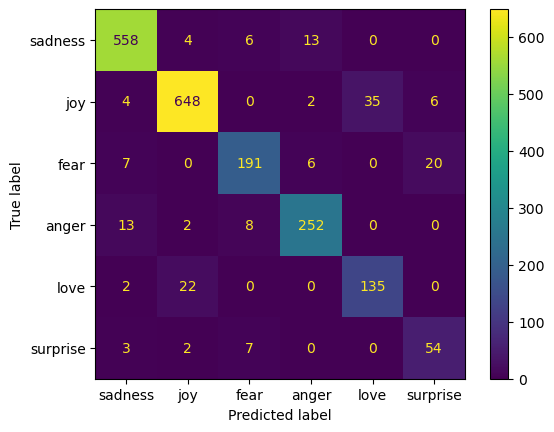

In [61]:
disp = ConfusionMatrixDisplay(confusion_matrix=cf_matrix, display_labels=labels) 
disp.plot() 
plt.show()